# Part 1, Model 1A: Basic Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) using JUST the fundus images of the eye. The features were extracted using the MobileNetV3 model.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-02-25 12:44:32.582017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 12:44:32.582108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 12:44:32.683025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 12:44:32.867827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 12:44:34.288355: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data[data['fundus_oc_seg'].notnull() & data['fundus_od_seg'].notnull()].info()

print(data['fundus_oc_seg'].notnull().value_counts())

data[data['fundus_oc_seg'].notnull()]

<class 'pandas.core.frame.DataFrame'>
Index: 3102 entries, 4546 to 12048
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     3102 non-null   object 
 1   types                     3102 non-null   int64  
 2   type_expanded             1848 non-null   object 
 3   isColor                   3102 non-null   int64  
 4   original_name             3102 non-null   object 
 5   patient_id                488 non-null    object 
 6   fundus                    3102 non-null   object 
 7   fundus_od_seg             3102 non-null   object 
 8   fundus_oc_seg             3102 non-null   object 
 9   bv_seg                    0 non-null      object 
 10  artery_seg                0 non-null      object 
 11  vein_seg                  0 non-null      object 
 12  oct                       44 non-null     object 
 13  oct_oc_seg                44 non-null     object 
 14  oct_od_se

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
4546,ORIGA-1,0,NaN,1,001.jpg,NaN,/full-fundus/ORIGA-1.png,/optic-disc/ORIGA-1.png,/optic-cup/ORIGA-1.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547,ORIGA-2,0,NaN,1,002.jpg,NaN,/full-fundus/ORIGA-2.png,/optic-disc/ORIGA-2.png,/optic-cup/ORIGA-2.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,ORIGA-3,0,NaN,1,003.jpg,NaN,/full-fundus/ORIGA-3.png,/optic-disc/ORIGA-3.png,/optic-cup/ORIGA-3.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4549,ORIGA-4,0,NaN,1,004.jpg,NaN,/full-fundus/ORIGA-4.png,/optic-disc/ORIGA-4.png,/optic-cup/ORIGA-4.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4550,ORIGA-5,0,NaN,1,005.jpg,NaN,/full-fundus/ORIGA-5.png,/optic-disc/ORIGA-5.png,/optic-cup/ORIGA-5.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,PAPILA-484,0,Healthy,1,289,PAPILA-289,/full-fundus/PAPILA-484.png,/optic-disc/PAPILA-484.png,/optic-cup/PAPILA-484.png,NaN,...,NaN,0.75,-1.5,93,1,10,,531,22.31,
12045,PAPILA-485,0,Healthy,1,290,PAPILA-290,/full-fundus/PAPILA-485.png,/optic-disc/PAPILA-485.png,/optic-cup/PAPILA-485.png,NaN,...,NaN,0.25,-0.25,160,1,19,,573,22.01,
12046,PAPILA-486,0,Healthy,1,291,PAPILA-291,/full-fundus/PAPILA-486.png,/optic-disc/PAPILA-486.png,/optic-cup/PAPILA-486.png,NaN,...,NaN,1.5,-1.25,76,0,14,,443,23.51,
12047,PAPILA-487,0,Healthy,1,292,PAPILA-292,/full-fundus/PAPILA-487.png,/optic-disc/PAPILA-487.png,/optic-cup/PAPILA-487.png,NaN,...,NaN,1.25,-0.75,79,0,9,,479,23.84,


In [8]:
data['fundus_oc_seg'].dtype

dtype('O')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [10]:
data['fundus_oc_seg'][12044]

'/optic-cup/PAPILA-484.png'

In [11]:
data['fundus_od_seg'][12044]

'/optic-disc/PAPILA-484.png'

In [12]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


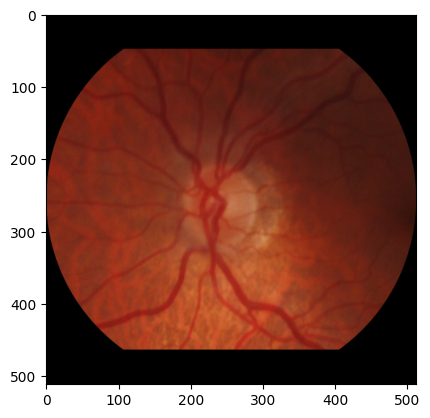

optic-cup/optic-cup/PAPILA-484.png


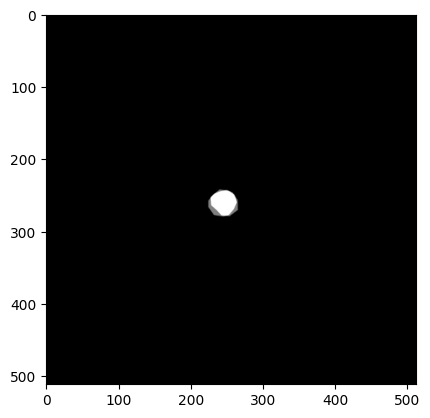

In [13]:
import os
import random

def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()


viewFundus(data['fundus'][12044])

In [14]:
data["types"].value_counts()

types
 0    7549
 1    4767
-1     133
Name: count, dtype: int64

In [15]:
data["types"].value_counts().sum()

12449

In [16]:
fundus_subset = data[(data['fundus'].notnull()) & (data['types'] != -1)]

fundus_subset = fundus_subset[['types', 'fundus', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   types     12316 non-null  object
 1   fundus    12316 non-null  object
 2   names     12316 non-null  object
 3   combined  12316 non-null  object
dtypes: object(4)
memory usage: 481.1+ KB


In [17]:
fundus_subset['types'].value_counts()

types
0    7549
1    4767
Name: count, dtype: int64

In [18]:
fundus_subset

,types,fundus,names,combined
0,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,OIA-ODIR-TEST-OFFLINE-1.png
1,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,OIA-ODIR-TEST-OFFLINE-2.png
2,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,OIA-ODIR-TEST-OFFLINE-4.png
3,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,OIA-ODIR-TEST-OFFLINE-5.png
4,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,OIA-ODIR-TEST-OFFLINE-6.png
...,...,...,...,...
12444,0,/full-fundus/FIVES-396.png,FIVES-396,FIVES-396.png
12445,0,/full-fundus/FIVES-397.png,FIVES-397,FIVES-397.png
12446,0,/full-fundus/FIVES-398.png,FIVES-398,FIVES-398.png
12447,0,/full-fundus/FIVES-399.png,FIVES-399,FIVES-399.png


In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

testSize = 500
valSize = 500

glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

print('Total fundus images to  be used: ', glaucomaCount + healthyCount)

random_state = 1

stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=valSize, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set, train_set['types']):
    train = train_set.iloc[train_index]
    val = train_set.iloc[val_index]

print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

train_features = train.drop('types', axis=1)
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 4767
this is the healthy eyes count 7549
Total fundus images to  be used:  12316

Train set size: 11316
Validation set size: 500
Test set size: 500


In [20]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  11316
Test Size:  500


In [21]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-25 12:44:36.959154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 12:44:37.240329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 12:44:37.240687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-02-25 12:44:37.270847: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 12:44:37.271384: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 12:44:37.271873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 12:44:37.701472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 12:44:37.701883: I external/local_xla/xla/stream_executor

Found 11316 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [23]:
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

with tf.device('/GPU:0'):

    classes = 'sparse'

    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = healthy_subsetDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [24]:
def show_images(gen):
    
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

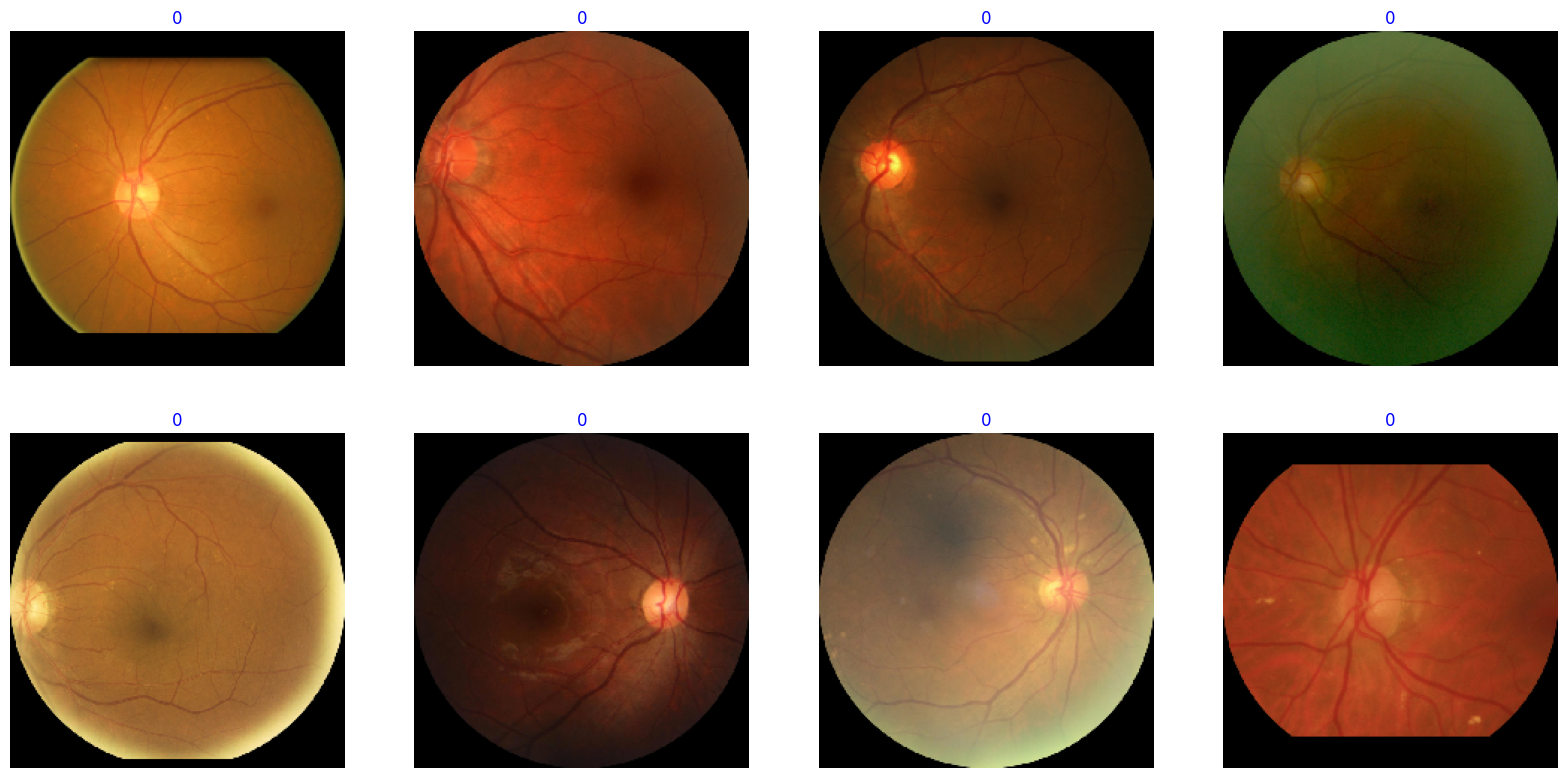

In [25]:
show_images(healthy_subset_Gen)

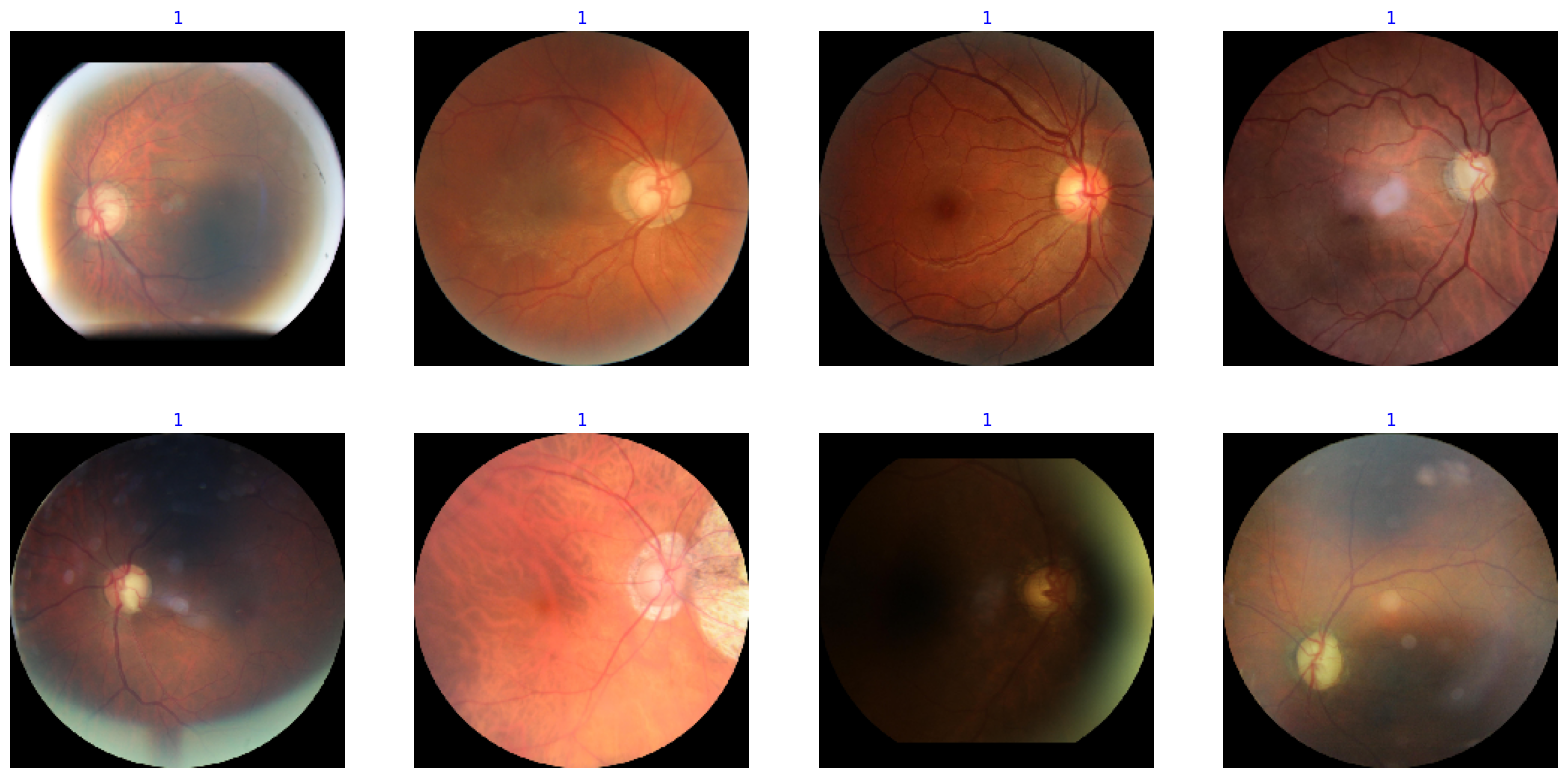

In [26]:
show_images(glaucoma_subset_Gen)

In [27]:
from keras.applications import MobileNetV3Small
from keras import Sequential

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

model = Sequential([
    base_model, layers.GlobalAveragePooling2D()
])

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

In [28]:
import numpy as np

train_features, train_labels = extract_features(trainGen, trainGen.samples)
val_features, val_labels = extract_features(valGen, valGen.samples)
test_features, test_labels = extract_features(testGen, testGen.samples)

2024-02-25 12:45:34.114389: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-25 12:45:34.553823: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


2024-02-25 12:45:35.658071: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 24ms/step


In [29]:
from sklearn.svm import SVC

with tf.device('/GPU:0'):

    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(train_features, train_labels)

In [30]:
val_accuracy = svm_model.score(val_features, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = svm_model.score(test_features, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.854
Test accuracy: 0.848


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = svm_model.predict(test_features)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[277  29]
 [ 47 147]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       306
         1.0       0.84      0.76      0.79       194

    accuracy                           0.85       500
   macro avg       0.85      0.83      0.84       500
weighted avg       0.85      0.85      0.85       500



In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=8, 
                                 weights='distance', 
                                 algorithm='auto', 
                                 leaf_size=30, 
                                 p=2, 
                                 metric='minkowski', 
                                 n_jobs=-1)

knn_model.fit(train_features, train_labels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, weights='distance')

In [33]:
val_accuracy = knn_model.score(val_features, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = knn_model.score(test_features, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.842
Test accuracy: 0.836


In [34]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = knn_model.predict(test_features)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[278  28]
 [ 54 140]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       306
         1.0       0.83      0.72      0.77       194

    accuracy                           0.84       500
   macro avg       0.84      0.82      0.82       500
weighted avg       0.84      0.84      0.83       500



In [35]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [36]:
val_accuracy = xgb_model.score(val_features, val_labels)
print('Validation accuracy:', val_accuracy)

test_accuracy = xgb_model.score(test_features, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.866
Test accuracy: 0.846


In [37]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = xgb_model.predict(test_features)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[277  29]
 [ 48 146]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       306
         1.0       0.83      0.75      0.79       194

    accuracy                           0.85       500
   macro avg       0.84      0.83      0.83       500
weighted avg       0.85      0.85      0.84       500



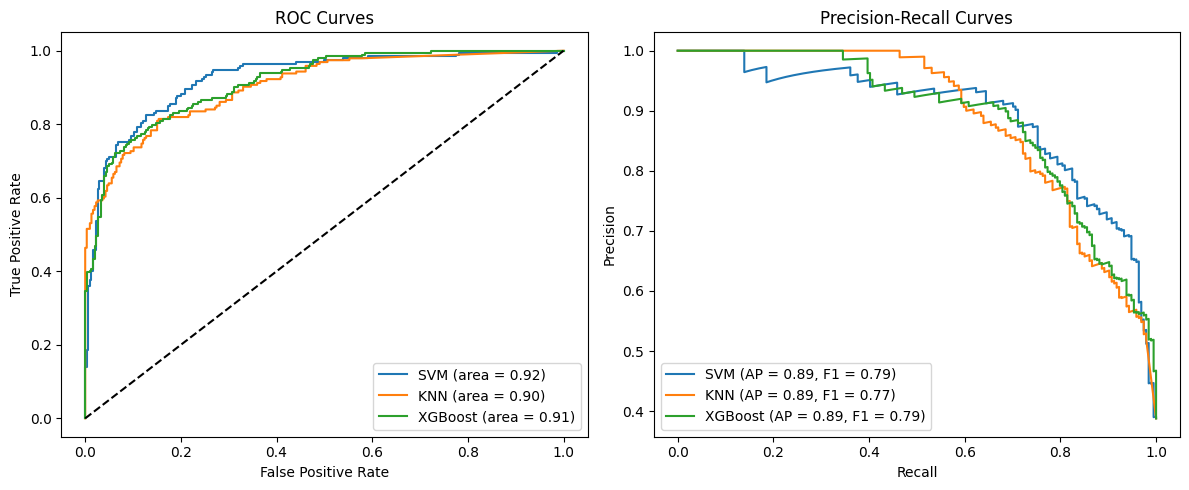

In [38]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

true_labels = test_labels
svm_probs = svm_model.predict_proba(test_features)[:, 1]

knn_probs = knn_model.predict_proba(test_features)[:, 1]

xgb_probs = xgb_model.predict_proba(test_features)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(true_labels, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(true_labels, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

precision_svm, recall_svm, _ = precision_recall_curve(true_labels, svm_probs)
ap_svm = average_precision_score(true_labels, svm_probs)
f1_svm = f1_score(true_labels, svm_probs.round())

precision_knn, recall_knn, _ = precision_recall_curve(true_labels, knn_probs)
ap_knn = average_precision_score(true_labels, knn_probs)
f1_knn = f1_score(true_labels, knn_probs.round())

precision_xgb, recall_xgb, _ = precision_recall_curve(true_labels, xgb_probs)
ap_xgb = average_precision_score(true_labels, xgb_probs)
f1_xgb = f1_score(true_labels, xgb_probs.round())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f}, F1 = {f1_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.2f}, F1 = {f1_knn:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f}, F1 = {f1_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()